In [1]:
######################################################################
# Modelling Sleep Duration Using Gaussian Processes
# LE49: MiniProject
# Jan Ondras (jo356), Trinity College
# 2017/2018
######################################################################
#########################################################################################
# INTERPRETATION in terms of ORTHOGONAL MEASURES (in terms of other measures than kernel parameters)
# FOR PERIODIC KERNEL 1: when clustered using periodicity only
# The following 3 measures are not used in the end - for future...
#                          bloodpressure, heartrate, weight
#########################################################################################
import numpy as np
user_info_dict = {}
for row in np.loadtxt('./../Dataset/userinfo.csv', delimiter=",", skiprows=1, dtype=str): # User info
    user_info_dict[row[1]] = row[2:] # city (0), timezone (1), gender (2), age (3), height (4)
print len(user_info_dict)

11614


In [8]:
# Load results from clustering
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import time
import glob

t = 'sleepduration' # type of data to extract
# extra_type = '_1_x1264'     # all 4 parameters used for clustering
extra_type = '_1_x1264_1only' # only periodicity used for clustering

types = {
    'sleepduration': '10',
    'bedin': '11',
    'bedout': '12',
    'steps': '1',
    'weight': '2',
    'bloodpressure': '4',
    'heartrate': '7'
}

data = np.load('./../Dataset/Clustering/clean_' + t + extra_type + '.npz')['c']
UIDs = data[:,0]
labels = data[:,1]

labels_unique = np.unique(labels)

K = len(labels_unique)
print K, "clusters found, with labels ", labels_unique
print "Total #users: ", len(data)


# To store all statistics: stats['cluster_label']
stats ={}
for label in labels_unique:
    stats[label] = {}
    stats[label]['size'] = 0.    # size of cluster
    stats[label]['M'] = 0.       # number of males
    stats[label]['F'] = 0.       # number of females
    stats[label]['SF'] = 0.      # from SanFrancisco
    stats[label]['LO'] = 0.      # from London
    stats[label]['m_bedin'] = 0.         # mean
    stats[label]['m_bedout'] = 0.        # mean
    stats[label]['m_sleepduration'] = 0. # mean
    stats[label]['m_steps'] = 0.         # mean
    stats[label]['m_age'] = 0.           # mean age
    stats[label]['m_height'] = 0.        # mean height 
    stats[label]['sleepduration'] = [[], [], [], [], [], [], []] # to calculate means for each weekday
    stats[label]['bedin'] = [[], [], [], [], [], [], []] # to calculate means for each weekday
    stats[label]['bedout'] = [[], [], [], [], [], [], []] # to calculate means for each weekday
    stats[label]['steps'] = [[], [], [], [], [], [], []] # to calculate means for each weekday
    stats[label]['bloodpressure'] = [[], [], [], [], [], [], []] # to calculate means for each weekday
    stats[label]['heartrate'] = [[], [], [], [], [], [], []] # to calculate means for each weekday
    stats[label]['weight'] = [[], [], [], [], [], [], []] # to calculate means for each weekday
    stats[label]['all_age'] = []        # to get standard deviations for age
    stats[label]['all_height'] = []     # to get standard deviations for height
    
# To balance the distributions: # to downsample some clusters to show independence between 
# observed patterns and different age/location/gender
# From C2 remove those with age > 46
rm_C2_age = 17
# From C1 remove those with height > 1.72
rm_C1_height = 180

# Iterate over clustering <UID, cluster label> pairs
for UID, label in data:
    
    # To balance the distributions:
#     if int(user_info_dict[UID][3]) > 46. and label == '2' and rm_C2_age > 0:
#         rm_C2_age -= 1
#         continue
#     if float(user_info_dict[UID][4]) > 1.72 and label == '1' and rm_C1_height > 0:
#         rm_C1_height -= 1
#         continue
    
    stats[label]['size'] += 1.   
    
    if user_info_dict[UID][0] == 'San Francisco':
        stats[label]['SF'] += 1.
    elif user_info_dict[UID][0] == 'London':
        stats[label]['LO'] += 1.
    else:
        print "err location"
    
    if user_info_dict[UID][2] == 'Male':
        stats[label]['M'] += 1.
    elif user_info_dict[UID][2] == 'Female':
        stats[label]['F'] += 1.
    else:
        print "err gender"
        
    stats[label]['m_age'] += int(user_info_dict[UID][3])
    stats[label]['m_height'] += float(user_info_dict[UID][4])
    
    stats[label]['all_age'].append(int(user_info_dict[UID][3]))
    stats[label]['all_height'].append(float(user_info_dict[UID][4]))
    
    # Mean bedin, bedout, and sleepduration
    user_d = np.load('./../Dataset/clean_sleepduration/' + UID + '.npz')['xy']
    stats[label]['m_sleepduration'] += np.mean(user_d[:,1]) # add mean of this user
    for x,y in user_d:
        stats[label]['sleepduration'][int(x+3)%7].append(y)
    
    user_d = np.load('./../Dataset/bedin/' + UID + '.npz')['xy']
    stats[label]['m_bedin'] += np.mean(user_d[:,1]) # add mean of this user
    for x,y in user_d:
        stats[label]['bedin'][int(x+3)%7].append(y)
    
    user_d = np.load('./../Dataset/bedout/' + UID + '.npz')['xy']
    stats[label]['m_bedout'] += np.mean(user_d[:,1]) # add mean of this user
    for x,y in user_d:
        stats[label]['bedout'][int(x+3)%7].append(y)
        
    user_d = np.load('./../Dataset/steps/' + UID + '.npz')['xy']
    stats[label]['m_steps'] += np.mean(user_d[:,1]) # add mean of this user
    for x,y in user_d:
        stats[label]['steps'][int(x+3)%7].append(y)
        
    # The following 3 measures are not used in the end - for future...
    try: 
        user_d = np.load('./../Dataset/bloodpressure/' + UID + '.npz')['xy']
        for x,y in user_d:
            stats[label]['bloodpressure'][int(x+3)%7].append(y)
    except:
        pass
    try:
        user_d = np.load('./../Dataset/heartrate/' + UID + '.npz')['xy']
        for x,y in user_d:
            stats[label]['heartrate'][int(x+3)%7].append(y)
    except:
        pass
    try:
        user_d = np.load('./../Dataset/weight/' + UID + '.npz')['xy']
        for x,y in user_d:
            stats[label]['weight'][int(x+3)%7].append(y)
    except:
        pass
    
for label in labels_unique:
    print "Cluster: ", label
    print "\tsize          ",  stats[label]['size']
    print "\t%males        ",  stats[label]['M']/stats[label]['size']
    print "\t%females      ",  stats[label]['F']/stats[label]['size']
    print "\tmean age      ",  stats[label]['m_age']/stats[label]['size'], np.mean(stats[label]['all_age']), '+/-' ,np.std(stats[label]['all_age'])
    print "\tmean height   ",  stats[label]['m_height']/stats[label]['size'], np.mean(stats[label]['all_height']), '+/-' ,np.std(stats[label]['all_height'])
    print "\t%San Francisco",  stats[label]['SF']/stats[label]['size']
    print "\t%London       ",  stats[label]['LO']/stats[label]['size']
    
    print "\tmean sleep duration [h]              ",  stats[label]['m_sleepduration']/stats[label]['size']
    print "\tmean bedin time                      ",  stats[label]['m_bedin']/stats[label]['size']
    print "\tmean bedout time                     ",  stats[label]['m_bedout']/stats[label]['size']
    print "\tmean step count                      ",  stats[label]['m_steps']/stats[label]['size']
    
    print "\tmean sleep duration [h] per weekday\n",  [np.mean(l) for l in stats[label]['sleepduration']]
    print "\tmean bedin time [h] per weekday\n",  [np.mean(l) for l in stats[label]['bedin']]
    print "\tmean bedout time [h] per weekday\n",  [np.mean(l) for l in stats[label]['bedout']]
    print "\tmean step count per weekday\n",  [np.mean(l) for l in stats[label]['steps']]

# print data


2 clusters found, with labels  ['1' '2']
Total #users:  1264
Cluster:  1
	size           1019.0
	%males         0.623159960746
	%females       0.376840039254
	mean age       45.6486751717 45.6486751717 +/- 13.5618463297
	mean height    1.73802747792 1.73802747792 +/- 0.100971411488
	%San Francisco 0.311089303238
	%London        0.688910696762
	mean sleep duration [h]               7.25841872053
	mean bedin time                       23.7147728546
	mean bedout time                      7.5189280278
	mean step count                       7483.46494905
	mean sleep duration [h] per weekday
[7.2110381802404859, 7.1117672174894793, 7.0749746224185754, 7.0954558354755779, 7.098504640630396, 7.5754415522363256, 7.6874812993561559]
	mean bedin time [h] per weekday
[23.519233867636121, 23.531237198037886, 23.576143320869463, 23.563757067373921, 23.662561624365484, 23.996606575422128, 24.139186249999998]
	mean bedout time [h] per weekday
[7.273154176650416, 7.1704447591486558, 7.1796084151703168,

sizes:  1019.0 245.0
distribution of gender/location between clusters (normalised by cluster size)


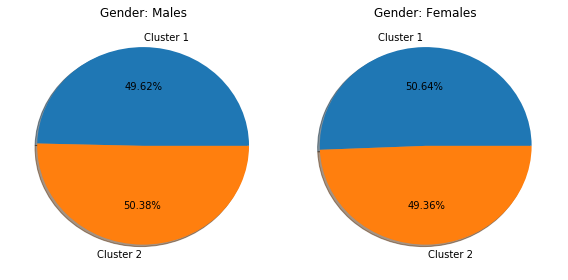

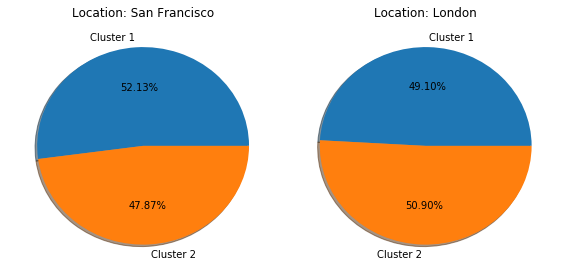

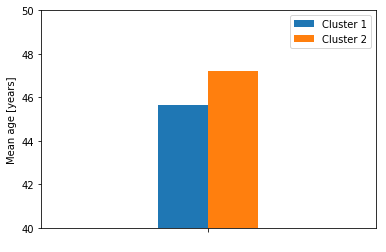

C 1  45.6486751717 +/- 13.5618463297
C 2  47.2 +/- 14.3423448969


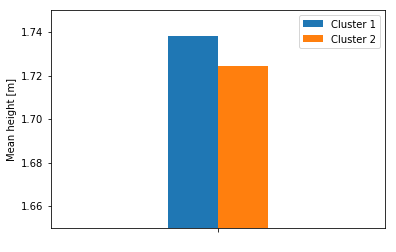

C 1  1.73802747792 +/- 0.100971411488
C 2  1.72420408163 +/- 0.0966240303892


In [9]:
###################################################################################
# Chosen stats
###################################################################################

labels_pie = ["Cluster "+label for label in labels_unique]
explode = [0.,0.05]

w1 = stats['1']['size']   #all these measures are weighted by cluster size
w2 = stats['2']['size']
W = w1 + w2
print "sizes: ", w1, w2
print "distribution of gender/location between clusters (normalised by cluster size)"

###################################### Gender
plt.figure(figsize=(8,4))

plt.subplot(121)
fracs = [stats['1']['M']/stats['1']['size'], stats['2']['M']/stats['2']['size']] # wrong
# fracs = [stats['1']['M'], stats['2']['M']]
fracs = fracs / np.sum(fracs)
plt.pie(fracs, labels=labels_pie, autopct='%.2f%%', shadow=True)#, explode=explode)#, radius=1.9)
plt.title('Gender: Males')

plt.subplot(122)
# fracs = [stats['1']['F'], stats['2']['F']]
fracs = [stats['1']['F']/stats['1']['size'], stats['2']['F']/stats['2']['size']]
fracs = fracs / np.sum(fracs)
plt.pie(fracs, labels=labels_pie, autopct='%.2f%%', shadow=True)#, explode=explode)#, radius=1.9)
plt.title('Gender: Females')

plt.tight_layout()
plt.show()

# plt.figure(figsize=(8,4))
# for i in ['1', '2']:
#     plt.subplot(1, 2, int(i))
#     fracs = [stats[i]['M'], stats[i]['F']]
#     fracs = fracs / np.sum(fracs)
#     plt.pie(fracs, labels=['Males', 'Females'], autopct='%.2f%%', shadow=True)#, explode=explode)#, radius=1.9)
#     plt.title('Cluster ' + i)
# plt.tight_layout()
# plt.show()

###################################### Location
plt.figure(figsize=(8,4))

plt.subplot(121)
fracs = [stats['1']['SF']/stats['1']['size'], stats['2']['SF']/stats['2']['size']]
# fracs = [stats['1']['SF'], stats['2']['SF']]
fracs = fracs / np.sum(fracs)
plt.pie(fracs, labels=labels_pie, autopct='%.2f%%', shadow=True)#, explode=explode)#, radius=1.9)
plt.title('Location: San Francisco')

plt.subplot(122)
fracs = [stats['1']['LO']/stats['1']['size'], stats['2']['LO']/stats['2']['size']]
# fracs = [stats['1']['LO'], stats['2']['LO']]
fracs = fracs / np.sum(fracs)
plt.pie(fracs, labels=labels_pie, autopct='%.2f%%', shadow=True)#, explode=explode)#, radius=1.9)
plt.title('Location: London')

plt.tight_layout()
plt.show()

# plt.figure(figsize=(8,4))
# for i in ['1', '2']:
#     plt.subplot(1, 2, int(i))
#     fracs = [stats[i]['SF'], stats[i]['LO']]
#     fracs = fracs / np.sum(fracs)
#     plt.pie(fracs, labels=['San Francisco', 'London'], autopct='%.2f%%', shadow=True)#, explode=explode)#, radius=1.9)
#     plt.title('Cluster ' + i)
# plt.tight_layout()
# plt.show()

###################################### Age
plt.figure()
w = 0.3
x = np.arange(1)
plt.bar(x-w/2, [stats['1']['m_age']/stats['1']['size']], 
        width=w, label='Cluster 1')
plt.bar(x, [stats['2']['m_age']/stats['2']['size']], 
        width=w, label='Cluster 2', align='edge')
#     plt.ylim(4,9)
plt.xlim(-1, 1)
plt.ylim(40, 50)
plt.ylabel('Mean age [years]')
plt.xticks(x," ")
# plt.xticks(x, ['Cluster 1', 'Cluster 2'])
plt.legend()
plt.show()
for l in ['1', '2']:
    print "C",l,"", np.mean(stats[l]['all_age']), '+/-' ,np.std(stats[l]['all_age'])

###################################### Height
plt.figure()
w = 0.3
x = np.arange(1)
plt.bar(x-w/2, [stats['1']['m_height']/stats['1']['size']], 
        width=w, label='Cluster 1')
plt.bar(x, [stats['2']['m_height']/stats['2']['size']], 
        width=w, label='Cluster 2', align='edge')
#     plt.ylim(4,9)
plt.xlim(-1, 1)
plt.ylim(1.65, 1.75)
plt.ylabel('Mean height [m]')
plt.xticks(x," ")
# plt.xticks(x, ['Cluster 1', 'Cluster 2'])
plt.legend()
plt.show()
for l in ['1', '2']:
    print "C",l,"", np.mean(stats[l]['all_height']), '+/-' ,np.std(stats[l]['all_height'])

## Before downsampling
### age
    C 1  45.6486751717 +/- 13.5618463297 
    C 2  47.2 +/- 14.3423448969
### height
    C 1  1.73802747792 +/- 0.100971411488
    C 2  1.72420408163 +/- 0.0966240303892

## After downsampling
### age
    C 1  45.9880810489 +/- 13.6563423473
    C 2  46.0745614035 +/- 14.0877158845
### height
    C 1  1.72339690107 +/- 0.0979894355422
    C 2  1.72289473684 +/- 0.0983078202187

### => means and stds better aligned

sleepduration
Weekdays mean (C1, C2) =  7.11834809925 7.20920189179
Weekends mean (C1, C2) =  7.6314614258 7.47085738497
bedin
Weekdays mean (C1, C2) =  23.5705866157 23.4067611635
Weekends mean (C1, C2) =  24.0678964127 23.8954807508
steps
Weekdays mean (C1, C2) =  7607.2270997 7775.68614834
Weekends mean (C1, C2) =  7471.56881521 7429.65452195
bedout
Weekdays mean (C1, C2) =  7.22139227999 7.23054395178
Weekends mean (C1, C2) =  8.27227070827 8.01194003396


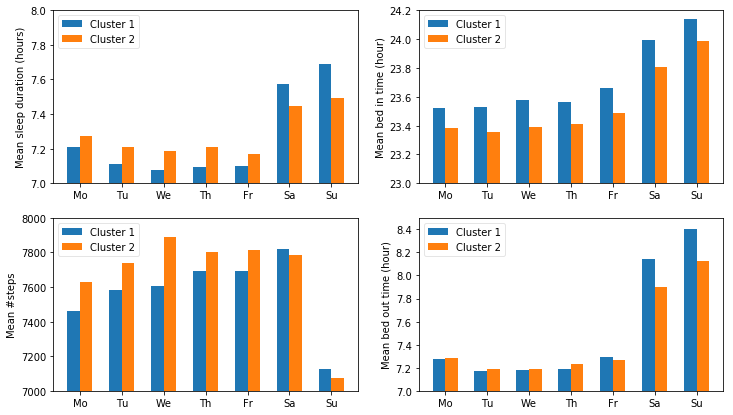

In [6]:
# Weekly stats
fig = plt.figure(figsize = (12,7))
for i, t in enumerate(['sleepduration', 'bedin', 'steps', 'bedout' ]):
    print t
    c1 = [np.mean(l) for l in stats['1'][t]]
    c2 = [np.mean(l) for l in stats['2'][t]]
    print "Weekdays mean (C1, C2) = ", np.mean(c1[:5]), np.mean(c2[:5])
    print "Weekends mean (C1, C2) = ", np.mean(c1[5:]), np.mean(c2[5:])
    
    ax = fig.add_subplot(2, 2, i+1)
    weekdays = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
    x = np.arange(7)
    w = 0.3
    ax.bar(x-w/2, [np.mean(l) for l in stats['1'][t]], 
            #yerr=[np.std(l) for l in stats['1'][t]], 
            width=w, label='Cluster 1'
            #, mean = '+str(np.mean([np.mean(l) for l in stats['1'][t]]))
           )
    ax.bar(x, [np.mean(l) for l in stats['2'][t]], 
            #yerr=[np.std(l) for l in stats['2'][t]], 
            width=w, label='Cluster 2'
            #, mean = '+str(np.mean([np.mean(l) for l in stats['2'][t]]))
            , align='edge')
    if t == 'sleepduration':
        ax.set_ylabel('Mean sleep duration (hours)')
        ax.set_ylim(7,8)
    elif t == 'bedin':
        ax.set_ylabel('Mean bed in time (hour)')
        ax.set_ylim(23,24.2)
    elif t == 'bedout':
        ax.set_ylabel('Mean bed out time (hour)')
        ax.set_ylim(7,8.5)
    elif t == 'steps':
        ax.set_ylabel('Mean #steps')
        ax.set_ylim(7000,8000)
    ax.set_xticks(x)
    ax.set_xticklabels(weekdays)
    ax.legend(loc='upper left', framealpha=0.5)
plt.show()
    
###################################################################################### 
# Separate plots
# for t in ['sleepduration', 'bedin', 'bedout', 'steps']:
#     plt.figure()
#     weekdays = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
#     x = np.arange(7)
#     w = 0.3
#     plt.bar(x-w/2, [np.mean(l) for l in stats['1'][t]], 
#             #yerr=[np.std(l) for l in stats['1'][t]], 
#             width=w, label='Cluster 1'
#             #, mean = '+str(np.mean([np.mean(l) for l in stats['1'][t]]))
#            )
#     plt.bar(x, [np.mean(l) for l in stats['2'][t]], 
#             #yerr=[np.std(l) for l in stats['2'][t]], 
#             width=w, label='Cluster 2'
#             #, mean = '+str(np.mean([np.mean(l) for l in stats['2'][t]]))
#             , align='edge')
#     if t == 'sleepduration':
#         plt.ylabel('Sleep duration (hours)')
#         plt.ylim(7,8)
#     elif t == 'bedin':
#         plt.ylabel('Bed in time (hour)')
#         plt.ylim(23,24.2)
#     elif t == 'bedout':
#         plt.ylabel('Bed out time (hour)')
#         plt.ylim(7,8.5)
#     elif t == 'steps':
#         plt.ylabel('#steps')
#         plt.ylim(7000,8000)
#     plt.xticks(x, weekdays)
#     plt.legend(loc='upper left')
#     plt.show()


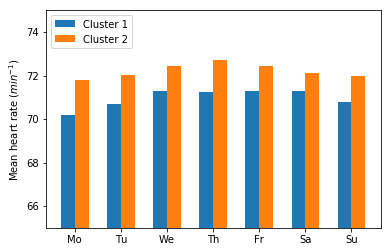

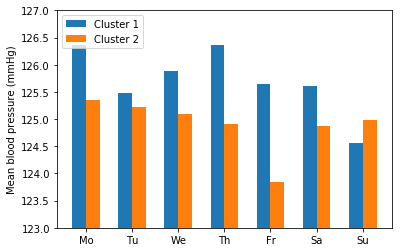

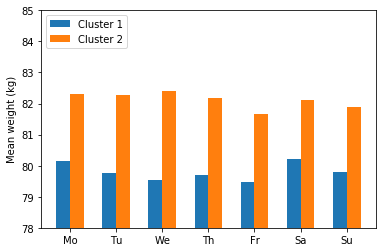

In [19]:
# FOR FUTURE

# Weekly stats
# fig = plt.figure(figsize = (12,6))
# for i, t in enumerate(['heartrate', 'bloodpressure', 'weight' ]):
#     print t
#     c1 = [np.mean(l) for l in stats['1'][t]]
#     c2 = [np.mean(l) for l in stats['2'][t]]
#     print "Weekdays mean (C1, C2) = ", np.mean(c1[:5]), np.mean(c2[:5])
#     print "Weekends mean (C1, C2) = ", np.mean(c1[5:]), np.mean(c2[5:])
    
#     ax = fig.add_subplot(2, 2, i+1)
#     weekdays = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
#     x = np.arange(7)
#     w = 0.3
#     ax.bar(x-w/2, [np.mean(l) for l in stats['1'][t]], 
#             #yerr=[np.std(l) for l in stats['1'][t]], 
#             width=w, label='Cluster 1'
#             #, mean = '+str(np.mean([np.mean(l) for l in stats['1'][t]]))
#            )
#     ax.bar(x, [np.mean(l) for l in stats['2'][t]], 
#             #yerr=[np.std(l) for l in stats['2'][t]], 
#             width=w, label='Cluster 2'
#             #, mean = '+str(np.mean([np.mean(l) for l in stats['2'][t]]))
#             , align='edge')
#     if t == 'heartrate':
#         ax.set_ylabel('Mean heart rate ($min^{-1}$)')
# #         ax.set_ylim(7,8)
#     elif t == 'bloodpressure':
#         ax.set_ylabel('Mean blood pressure (mmHg)')
# #         ax.set_ylim(23,24.2)
#     elif t == 'weight':
#         ax.set_ylabel('Mean weight (kg)')
# #         ax.set_ylim(7,8.5)

#     ax.set_xticks(x)
#     ax.set_xticklabels(weekdays)
#     ax.legend(loc='upper left', framealpha=0.5)
# plt.show()
    
###################################################################################### 
# Separate plots
for i, t in enumerate(['heartrate', 'bloodpressure', 'weight' ]):
    plt.figure()
    weekdays = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
    x = np.arange(7)
    w = 0.3
    plt.bar(x-w/2, [np.mean(l) for l in stats['1'][t]], 
            #yerr=[np.std(l) for l in stats['1'][t]], 
            width=w, label='Cluster 1'
            #, mean = '+str(np.mean([np.mean(l) for l in stats['1'][t]]))
           )
    plt.bar(x, [np.mean(l) for l in stats['2'][t]], 
            #yerr=[np.std(l) for l in stats['2'][t]], 
            width=w, label='Cluster 2'
            #, mean = '+str(np.mean([np.mean(l) for l in stats['2'][t]]))
            , align='edge')
    if t == 'heartrate':
        plt.ylabel('Mean heart rate ($min^{-1}$)')
        plt.ylim(65,75)
    elif t == 'bloodpressure':
        plt.ylabel('Mean blood pressure (mmHg)')
        plt.ylim(123,127)
    elif t == 'weight':
        plt.ylabel('Mean weight (kg)')
        plt.ylim(78,85)
    plt.xticks(x, weekdays)
    plt.legend(loc='upper left')
    plt.show()
